In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import glob
import os
from utility import *
from UnitGaussianNormalizer import *
import torch.nn.functional as F
import torch
from CustomDataset import *
import pickle
from FNO4D import *
import json
from visulization_compare import *
plt.jet()

<Figure size 432x288 with 0 Axes>

In [2]:
def print_gpu_memory_usage():
    print(f"Allocated: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")
    print(f"Cached:    {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")

In [3]:
NORMALIZER_DICT = {}
d_in, d_out = {}, {}
for key in ['GLOBAL', 'LGR1', 'LGR2', 'LGR3', 'LGR4']:
    with open(f"normalizer/input_normalizer_{key}_DP_val.pickle", 'rb') as f:
        input_normalizer = pickle.load(f)
    with open(f"normalizer/output_normalizer_{key}_DP_val.pickle", 'rb') as f:
        output_normalizer = pickle.load(f)
    input_normalizer.cuda()
    output_normalizer.cuda()
    d_in[key] = input_normalizer
    d_out[key] = output_normalizer
NORMALIZER_DICT['input'] = d_in
NORMALIZER_DICT['output'] = d_out

print(NORMALIZER_DICT.keys())
print(NORMALIZER_DICT['input'].keys(), NORMALIZER_DICT['output'].keys())

dict_keys(['input', 'output'])
dict_keys(['GLOBAL', 'LGR1', 'LGR2', 'LGR3', 'LGR4']) dict_keys(['GLOBAL', 'LGR1', 'LGR2', 'LGR3', 'LGR4'])


In [4]:
print_gpu_memory_usage()

Allocated: 0.01 MB
Cached:    2.00 MB


In [41]:
PATH = {}
PATH['GLOBAL'] = "pre_trained_models/FNO4D-GLOBAL-DP.pt"
PATH['LGR1'] = "pre_trained_models/FNO4D-LGR1-DP.pt"
PATH['LGR2'] = "pre_trained_models/FNO4D-LGR2-DP.pt"
PATH['LGR3'] = "pre_trained_models/FNO4D-LGR3-DP.pt"
PATH['LGR4'] = "pre_trained_models/FNO4D-LGR4-DP.pt"
device = torch.device('cuda')

MODEL_DICT = {}
for key in ['GLOBAL', 'LGR1', 'LGR2', 'LGR3', 'LGR4']:
    model = torch.load(PATH[key])
    model.eval()
    model.to(device)
    torch.cuda.empty_cache()
    MODEL_DICT[key] = model
    
print(MODEL_DICT.keys())

dict_keys(['GLOBAL', 'LGR1', 'LGR2', 'LGR3', 'LGR4'])


In [10]:
print_gpu_memory_usage()

Allocated: 5248.16 MB
Cached:    5250.00 MB


In [11]:
DATA_LOADER_DICT = torch.load('DATA_LOADER_DICT.pth')
train_loader = DATA_LOADER_DICT['GLOBAL']['train']
val_loader = DATA_LOADER_DICT['GLOBAL']['val']
test_loader = DATA_LOADER_DICT['GLOBAL']['test']
n_train = len(train_loader)
n_val = len(val_loader)
n_test = len(test_loader)
print(n_train, n_val, n_test)

16 2 2


In [12]:
def plot_z_comparison():
    plt.figure(figsize=(10,4.2))
    z=0
    t = 24
    cmin, cmax = 0, 10

    plt.jet()
    plt.subplot(1,2,1)
    plot_z_slice(z=z,WELL_LIST=WELL_LIST, LGR_LIST=meta_data[f'case_{idx}']['LGR_LIST'],
                 PCOLOR_GRID_DICT = meta_data[f'case_{idx}']['PCOLOR_GRID_DICT'],
                 GRID_IDX_DICT=meta_data[f'case_{idx}']['GRID_IDX_DICT'],
                 OUTPUT_DICT=dict_convert_torch_to_numpy(TRUE),
                 cmin=cmin,cmax=cmax,
                 xmin=0,xmax=160000,
                 ymin=0,ymax=160000,
                 grid_on=False, title=f'True',boundary_on=True)

    plt.subplot(1,2,2)
    plot_z_slice(z=z,WELL_LIST=WELL_LIST, LGR_LIST=meta_data[f'case_{idx}']['LGR_LIST'],
                 PCOLOR_GRID_DICT = meta_data[f'case_{idx}']['PCOLOR_GRID_DICT'],
                 GRID_IDX_DICT=meta_data[f'case_{idx}']['GRID_IDX_DICT'],
                 OUTPUT_DICT=dict_convert_torch_to_numpy(PRED),
                 cmin=cmin,cmax=cmax,
                 xmin=0,xmax=160000,
                 ymin=0,ymax=160000,
                 grid_on=False, title=f'Pred',boundary_on=True)

    plt.tight_layout()
    plt.show()

In [13]:
def plot_x_comparison():
    for well in WELL_LIST:
        plt.figure(figsize=(10,1.5))
        z=0
        t = 24
        cmin, cmax = 0, 15
        x, y = meta_data[f'case_{idx}']['INJ_LOCATION_DICT'][well][0], meta_data[f'case_{idx}']['INJ_LOCATION_DICT'][well][1]
        plt.subplot(1,2,1)
        plot_x_slice(x=x, WELL_LIST=WELL_LIST, LGR_LIST=meta_data[f'case_{idx}']['LGR_LIST'],
                     PCOLOR_GRID_DICT = meta_data[f'case_{idx}']['PCOLOR_GRID_DICT'],
                     GRID_IDX_DICT=meta_data[f'case_{idx}']['GRID_IDX_DICT'],
                     OUTPUT_DICT=dict_convert_torch_to_numpy(TRUE),
                     cmin=cmin,cmax=cmax,
                     xmin=y-4000,xmax=y+4000,
                     ymin=0,ymax=100,
                     title=f', {well}, True',boundary_on=True)
        plt.subplot(1,2,2)
        plot_x_slice(x=x, WELL_LIST=WELL_LIST, LGR_LIST=meta_data[f'case_{idx}']['LGR_LIST'],
                     PCOLOR_GRID_DICT = meta_data[f'case_{idx}']['PCOLOR_GRID_DICT'],
                     GRID_IDX_DICT=meta_data[f'case_{idx}']['GRID_IDX_DICT'],
                     OUTPUT_DICT=dict_convert_torch_to_numpy(PRED),
                     cmin=cmin,cmax=cmax,
                     xmin=y-4000,xmax=y+4000,
                     ymin=0,ymax=100,
                     title=f', {well}, Pred',boundary_on=True)
        plt.tight_layout()
        plt.show()

In [51]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import operator
from functools import reduce
from functools import partial

from timeit import default_timer

torch.manual_seed(0)
np.random.seed(0)

class SpectralConv4d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3, modes4):
        super(SpectralConv4d, self).__init__()

        """
        4D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3
        self.modes4 = modes4
        
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, self.modes4, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, self.modes4, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, self.modes4, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, self.modes4, dtype=torch.cfloat))
        self.weights5 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, self.modes4, dtype=torch.cfloat))
        self.weights6 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, self.modes4, dtype=torch.cfloat))
        self.weights7 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, self.modes4, dtype=torch.cfloat))
        self.weights8 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, self.modes4, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul4d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyzt,ioxyzt->boxyzt", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-4,-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-4), x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3, :self.modes4] = self.compl_mul4d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3, :self.modes4], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3, :self.modes4] = self.compl_mul4d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3, :self.modes4], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3, :self.modes4] = self.compl_mul4d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3, :self.modes4], self.weights3)
        out_ft[:, :, :self.modes1, :self.modes2, -self.modes3:, :self.modes4] = self.compl_mul4d(x_ft[:, :, :self.modes1, :self.modes2, -self.modes3:, :self.modes4], self.weights4)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3, :self.modes4] = self.compl_mul4d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3, :self.modes4], self.weights5)
        out_ft[:, :, -self.modes1:, :self.modes2, -self.modes3:, :self.modes4] = self.compl_mul4d(x_ft[:, :, -self.modes1:, :self.modes2, -self.modes3:, :self.modes4], self.weights6)
        out_ft[:, :, :self.modes1, -self.modes2:, -self.modes3:, :self.modes4] = self.compl_mul4d(x_ft[:, :, :self.modes1, -self.modes2:, -self.modes3:, :self.modes4], self.weights7)
        out_ft[:, :, -self.modes1:, -self.modes2:, -self.modes3:, :self.modes4] = self.compl_mul4d(x_ft[:, :, -self.modes1:, -self.modes2:, -self.modes3:, :self.modes4], self.weights8)        

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-4), x.size(-3), x.size(-2), x.size(-1)))
        return x

class Block4d(nn.Module):
    def __init__(self, width, width2, modes1, modes2, modes3, modes4, out_dim):
        super(Block4d, self).__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.modes4 = modes4
        
        self.width = width
        self.width2 = width2
        self.out_dim = out_dim
        self.padding = 8
        
        # channel
        self.conv0 = SpectralConv4d(self.width, self.width, self.modes1, self.modes2, self.modes3, self.modes4)
        self.conv1 = SpectralConv4d(self.width, self.width, self.modes1, self.modes2, self.modes3, self.modes4)
        self.conv2 = SpectralConv4d(self.width, self.width, self.modes1, self.modes2, self.modes3, self.modes4)
        self.conv3 = SpectralConv4d(self.width, self.width, self.modes1, self.modes2, self.modes3, self.modes4)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.fc1 = nn.Linear(self.width, self.width2)
        self.fc2 = nn.Linear(self.width2, self.out_dim)
        
    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y, size_z, size_t = x.shape[2], x.shape[3], x.shape[4], x.shape[5]
#         print(size_x, size_y, size_z, size_t)
        # channel
        print(x.shape)
        print(x.dtype)
        x1 = self.conv0(x)
        print(x1.shape)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z, size_t)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z, size_t)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z, size_t)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z, size_t)
        x = x1 + x2
        
        x = x[:, :, self.padding:-self.padding, self.padding*2:-self.padding*2, 
              self.padding*2:-self.padding*2, self.padding:-self.padding]
        
        x = x.permute(0, 2, 3, 4, 5, 1)  # pad the domain if input is non-periodic
        x1 = self.fc1(x)
        x = F.gelu(x1)
        x = self.fc2(x)
        
        return x
    
class FNO4d(nn.Module):
    def __init__(self, modes1, modes2, modes3, modes4, width, in_dim):
        super(FNO4d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.modes4 = modes4
        self.width = width
        self.width2 = width*4
        self.in_dim = in_dim
        self.out_dim = 1
        self.padding = 8  # pad the domain if input is non-periodic
        
        self.fc0 = nn.Linear(self.in_dim, self.width)
        self.conv = Block4d(self.width, self.width2, 
                               self.modes1, self.modes2, self.modes3, self.modes4, self.out_dim)

    def forward(self, x, gradient=False):
        x = self.fc0(x) 
        x = x.permute(0, 5, 1, 2, 3, 4)
        x = F.pad(x, [self.padding, self.padding, self.padding*2, self.padding*2, self.padding*2, 
                      self.padding*2, self.padding, self.padding])  
        
        x = self.conv(x)
    
        return x
    
    
    

In [53]:
width = 28
mode1, mode2, mode3, mode4 = 4, 20, 20, 2
model_global = FNO4d(mode1, mode2, mode3, mode4, width, in_dim=8)
model_global

FNO4d(
  (fc0): Linear(in_features=8, out_features=28, bias=True)
  (conv): Block4d(
    (conv0): SpectralConv4d()
    (conv1): SpectralConv4d()
    (conv2): SpectralConv4d()
    (conv3): SpectralConv4d()
    (w0): Conv1d(28, 28, kernel_size=(1,), stride=(1,))
    (w1): Conv1d(28, 28, kernel_size=(1,), stride=(1,))
    (w2): Conv1d(28, 28, kernel_size=(1,), stride=(1,))
    (w3): Conv1d(28, 28, kernel_size=(1,), stride=(1,))
    (fc1): Linear(in_features=28, out_features=112, bias=True)
    (fc2): Linear(in_features=112, out_features=1, bias=True)
  )
)

In [54]:
model_global.load_state_dict(MODEL_DICT['GLOBAL'].state_dict())

<All keys matched successfully>

In [56]:
it = iter(test_loader)

for counter in range(1):
        with torch.no_grad():
            torch.cuda.reset_peak_memory_stats()

            PRED, TRUE = {}, {}
            data = next(it)
            x, y, path = data['x'], data['y'], data['path']
            x, y = x[None,...].to(device), y[None,...]
            x[...,-1:] = NORMALIZER_DICT['input']['GLOBAL'].encode(x.to(device)[...,-1:])
            torch.cuda.empty_cache()
            print_gpu_memory_usage()
            
            x = x.half()
#             MODEL_DICT['GLOBAL'].half()
            model_global.half()
            
#             MODEL_DICT['GLOBAL'].to(device)
            model_global.to(device)
#             pred = NORMALIZER_DICT['output']['GLOBAL'].decode(MODEL_DICT['GLOBAL'](x)).cpu()
            pred = NORMALIZER_DICT['output']['GLOBAL'].decode(model_global(x)).cpu()

#             MODEL_DICT['GLOBAL'].cpu()
            PRED['GLOBAL'] = pred
            TRUE['GLOBAL'] = y
            slope, idx, well = path[0], path[1], path[2]

            meta_data = np.load(f'ECLIPSE/meta_data/{slope}_{idx}.npy', allow_pickle=True).tolist()
            WELL_LIST = meta_data[f'case_{idx}']['WELL_LIST']
            GRID_IDX_DICT = meta_data[f'case_{idx}']['GRID_IDX_DICT']
            
            peak_memory_usage_bytes = torch.cuda.max_memory_allocated()
            peak_memory_usage_mb = peak_memory_usage_bytes / (1024 * 1024)
            print("Peak memory usage: {:.2f} MB".format(peak_memory_usage_mb))
            torch.cuda.empty_cache()

print_gpu_memory_usage()

Allocated: 7479.10 MB
Cached:    8288.00 MB
torch.Size([1, 28, 40, 132, 132, 21])
torch.float16


RuntimeError: cuFFT only supports dimensions whose sizes are powers of two when computing in half precision, but got a signal size of[21]

In [71]:
x = torch.rand(1, 28, 40, 132, 132, 22)
x = x.half()
x = x.to(device)
y = torch.fft.rfftn(x, dim=[-4,-3,-2,-1])

RuntimeError: cuFFT only supports dimensions whose sizes are powers of two when computing in half precision, but got a signal size of[22]

In [68]:
2**3, 2**4, 2**5, 2**6, 2**7

(8, 16, 32, 64, 128)

In [70]:
x = torch.rand(1, 32, 64, 128, 128, 32)
x = x.half()
x = x.to(device)
y = torch.fft.rfftn(x, dim=[-4,-3,-2,-1])

In [21]:
x = x.half()
x.dtype

torch.float32

In [19]:
for name, param in MODEL_DICT['GLOBAL'].named_parameters():
    print(f"{name} : {param.dtype}")

fc0.weight : torch.float16
fc0.bias : torch.float16
conv.conv0.weights1 : torch.complex64
conv.conv0.weights2 : torch.complex64
conv.conv0.weights3 : torch.complex64
conv.conv0.weights4 : torch.complex64
conv.conv0.weights5 : torch.complex64
conv.conv0.weights6 : torch.complex64
conv.conv0.weights7 : torch.complex64
conv.conv0.weights8 : torch.complex64
conv.conv1.weights1 : torch.complex64
conv.conv1.weights2 : torch.complex64
conv.conv1.weights3 : torch.complex64
conv.conv1.weights4 : torch.complex64
conv.conv1.weights5 : torch.complex64
conv.conv1.weights6 : torch.complex64
conv.conv1.weights7 : torch.complex64
conv.conv1.weights8 : torch.complex64
conv.conv2.weights1 : torch.complex64
conv.conv2.weights2 : torch.complex64
conv.conv2.weights3 : torch.complex64
conv.conv2.weights4 : torch.complex64
conv.conv2.weights5 : torch.complex64
conv.conv2.weights6 : torch.complex64
conv.conv2.weights7 : torch.complex64
conv.conv2.weights8 : torch.complex64
conv.conv3.weights1 : torch.complex6

In [23]:
it = iter(test_loader)

for counter in range(1):
        with torch.no_grad():
            torch.cuda.reset_max_memory_allocated()

            PRED, TRUE = {}, {}
            data = next(it)
            x, y, path = data['x'], data['y'], data['path']
            x, y = x[None,...].to(device), y[None,...]
            x[...,-1:] = NORMALIZER_DICT['input']['GLOBAL'].encode(x.to(device)[...,-1:])
            x.half()
            MODEL_DICT['GLOBAL'](x).half()
            pred = NORMALIZER_DICT['output']['GLOBAL'].decode(MODEL_DICT['GLOBAL'](x)).cpu()
            PRED['GLOBAL'] = pred
            TRUE['GLOBAL'] = y
            slope, idx, well = path[0], path[1], path[2]

            meta_data = np.load(f'ECLIPSE/meta_data/{slope}_{idx}.npy', allow_pickle=True).tolist()
            WELL_LIST = meta_data[f'case_{idx}']['WELL_LIST']
            GRID_IDX_DICT = meta_data[f'case_{idx}']['GRID_IDX_DICT']
            peak_memory_usage_bytes = torch.cuda.max_memory_allocated()
            peak_memory_usage_mb = peak_memory_usage_bytes / (1024 * 1024)
            print("Peak memory usage: {:.2f} MB".format(peak_memory_usage_mb))
            torch.cuda.empty_cache()
print_gpu_memory_usage()

Peak memory usage: 21495.57 MB
Allocated: 5488.32 MB
Cached:    6062.00 MB


Allocated: 5934.00 MB
Cached:    22982.00 MB
LGR1
Allocated: 5966.96 MB
Cached:    6542.00 MB
LGR2
Allocated: 6032.96 MB
Cached:    6608.00 MB
LGR3
Allocated: 6098.96 MB
Cached:    6674.00 MB
LGR4
Allocated: 6128.34 MB
Cached:    6702.00 MB
LGR1
Allocated: 6128.34 MB
Cached:    6702.00 MB
LGR2
Allocated: 6128.34 MB
Cached:    6702.00 MB
LGR3
Allocated: 6128.34 MB
Cached:    6702.00 MB
LGR4
Allocated: 6128.34 MB
Cached:    6702.00 MB
LGR1
Allocated: 6128.34 MB
Cached:    6702.00 MB
LGR2
Allocated: 6128.34 MB
Cached:    6702.00 MB
LGR3
Allocated: 6128.34 MB
Cached:    6702.00 MB
LGR4
Allocated: 6128.34 MB
Cached:    6702.00 MB
LGR1
Allocated: 6128.34 MB
Cached:    6702.00 MB
LGR2
Allocated: 6128.34 MB
Cached:    6702.00 MB
LGR3
Allocated: 6128.34 MB
Cached:    6702.00 MB
LGR4
Allocated: 6128.34 MB
Cached:    6702.00 MB


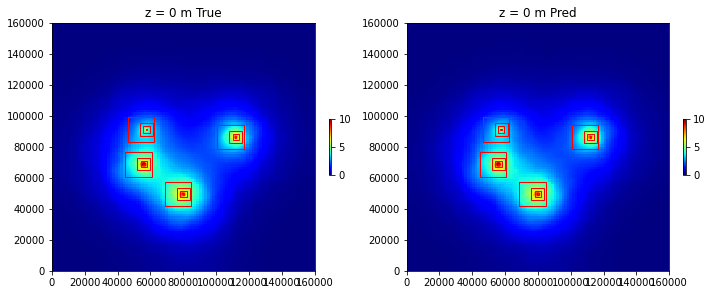

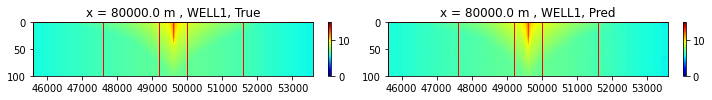

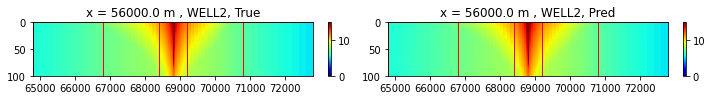

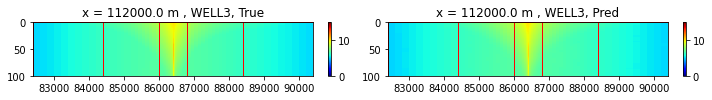

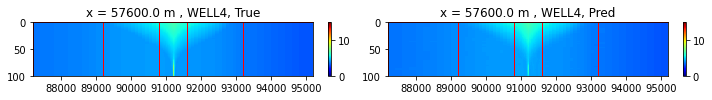

In [19]:
it = iter(test_loader)

for counter in range(1):

    with torch.no_grad():
        PRED, TRUE = {}, {}
        data = next(it)
        x, y, path = data['x'], data['y'], data['path']
        x, y = x[None,...].to(device), y[None,...]
        x[...,-1:] = NORMALIZER_DICT['input']['GLOBAL'].encode(x.to(device)[...,-1:])
        pred = NORMALIZER_DICT['output']['GLOBAL'].decode(MODEL_DICT['GLOBAL'](x)).cpu()
        PRED['GLOBAL'] = pred
        TRUE['GLOBAL'] = y
        slope, idx, well = path[0], path[1], path[2]

        meta_data = np.load(f'ECLIPSE/meta_data/{slope}_{idx}.npy', allow_pickle=True).tolist()
        WELL_LIST = meta_data[f'case_{idx}']['WELL_LIST']
        GRID_IDX_DICT = meta_data[f'case_{idx}']['GRID_IDX_DICT']

        print_gpu_memory_usage()
        torch.cuda.empty_cache()

        for well in WELL_LIST:
            lgr_dict, true_dict = {}, {}

            data_LGR1 = torch.load(f'dataset/dP_LGR1/{slope}_{idx}_LGR1_{well}_DP.pt')
            I1, I2 = GRID_IDX_DICT[well]['LGR1']['I1']-1-15, GRID_IDX_DICT[well]['LGR1']['I2']+15
            J1, J2 = GRID_IDX_DICT[well]['LGR1']['J1']-1-15, GRID_IDX_DICT[well]['LGR1']['J2']+15
            coarse = np.repeat(PRED['GLOBAL'][0,...][:,I1:I2,J1:J2,:,:],5,axis=-2).permute(-1,1,2,3,0)[...,None]
            x_LGR1 = torch.cat((data_LGR1['input'][...,:-1],coarse),axis=-1)
            x_LGR1 = x_LGR1.permute(0,4,1,2,3,5).to(device)
            x_LGR1[...,-1:] = NORMALIZER_DICT['input']['LGR1'].encode(x_LGR1.to(device)[...,-1:])
            pred = NORMALIZER_DICT['output']['LGR1'].decode(MODEL_DICT['LGR1'](x_LGR1)).cpu()
            lgr_dict['LGR1'] = pred
            y = data_LGR1['output'][...,:1].permute(0,4,1,2,3,5)
            true_dict['LGR1'] = y

            print('LGR1')
            torch.cuda.empty_cache()
            print_gpu_memory_usage()

            data_LGR2 = torch.load(f'dataset/dP_LGR2/{slope}_{idx}_LGR2_{well}_DP.pt')
            coarse = np.repeat(lgr_dict['LGR1'][0,...],2,axis=-2).permute(-1,1,2,3,0)[...,None]
            x_LGR2 = torch.cat((data_LGR2['input'][...,:-1],coarse),axis=-1)
            x_LGR2 = x_LGR2.permute(0,4,1,2,3,5).to(device)
            x_LGR2[...,-1:] = NORMALIZER_DICT['input']['LGR2'].encode(x_LGR2.to(device)[...,-1:])
            pred = NORMALIZER_DICT['output']['LGR2'].decode(MODEL_DICT['LGR2'](x_LGR2)).cpu()
            lgr_dict['LGR2'] = pred
            y = data_LGR2['output'][...,:1].permute(0,4,1,2,3,5)
            true_dict['LGR2'] = y

            print('LGR2')
            torch.cuda.empty_cache()
            print_gpu_memory_usage()

            data_LGR3 = torch.load(f'dataset/dP_LGR3/{slope}_{idx}_LGR3_{well}_DP.pt')
            coarse = lgr_dict['LGR2'][0,...].permute(-1,1,2,3,0)[...,None]
            x_LGR3 = torch.cat((data_LGR3['input'][...,:-1],coarse),axis=-1)
            x_LGR3 = x_LGR3.permute(0,4,1,2,3,5).to(device)
            x_LGR3[...,-1:] = NORMALIZER_DICT['input']['LGR3'].encode(x_LGR3.to(device)[...,-1:])
            pred = NORMALIZER_DICT['output']['LGR3'].decode(MODEL_DICT['LGR3'](x_LGR3)).cpu()
            lgr_dict['LGR3'] = pred
            y = data_LGR3['output'][...,:1].permute(0,4,1,2,3,5)
            true_dict['LGR3'] = y

            print('LGR3')
            torch.cuda.empty_cache()
            print_gpu_memory_usage()

            data_LGR4 = torch.load(f'dataset/dP_LGR4/{slope}_{idx}_LGR4_{well}_DP.pt')
            coarse = lgr_dict['LGR3'][0,...].permute(-1,1,2,3,0)[...,None]
            x = data_LGR4['input']
            x_LGR4 = torch.cat((x[...,:-1],coarse),axis=-1)
            x_LGR4 = x_LGR4.permute(0,4,1,2,3,5).to(device)
            x_LGR4[...,-1:] = NORMALIZER_DICT['input']['LGR4'].encode(x_LGR4.to(device)[...,-1:])
            pred = NORMALIZER_DICT['output']['LGR4'].decode(MODEL_DICT['LGR4'](x_LGR4)).cpu()
            lgr_dict['LGR4'] = pred
            y = data_LGR4['output'][...,:1].permute(0,4,1,2,3,5)
            true_dict['LGR4'] = y

            print('LGR4')
            torch.cuda.empty_cache()
            print_gpu_memory_usage()

            PRED[well] = lgr_dict
            TRUE[well] = true_dict

        plot_z_comparison()
        plot_x_comparison()


In [11]:
! nvidia-smi

Fri Mar 17 15:42:29 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB           On | 00000000:84:00.0 Off |                    0 |
| N/A   32C    P0               68W / 400W|   7589MiB / 81920MiB |      0%   E. Process |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# Change to
with torch.autocast(device_type='cuda', dtype=torch.float16):
    with torch.no_grad():
        output = fno(input)